<a href="https://colab.research.google.com/github/AlwaysEden/Temperature-Forecast/blob/main/ARIMA_Family.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from os.path import split
import requests
import json
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
from zoneinfo import ZoneInfo

In [ ]:
def temp_totalData():  #기상청API에서 온도 데이터를 받아 파싱
  now = datetime.now(ZoneInfo('Asia/Seoul'))
  one_month_ago = now - timedelta(days=30) #한번에 받아올 수 있는 데이터 최대 30일

  startDt = one_month_ago.strftime("%Y%m%d%H00")
  endDt = now.strftime("%Y%m%d%H00")
  print(startDt)
  print(endDt)

  # URL 문자열, stn=138(포항) 자세한 사항 기상청 참고
  url = 'https://apihub.kma.go.kr/api/typ01/url/kma_sfctm5.php?tm1={startDt}&tm2={endDt}&obs=TA&stn=138&help=0&authKey=YOUR KEY'.format(startDt=startDt, endDt=endDt)

  # GET 요청
  response = requests.get(url)

  splited_response = response.text.splitlines()
  result_lines = splited_response[3:len(splited_response) - 1]

  # 데이터 파싱
  temperature_list = []
  for line in result_lines:
    line = line.split(',')
    temperature_list.append(float(line[5]))


  date_rng = pd.date_range(start=startDt, end=endDt, freq='h')
  df = pd.DataFrame({'date': date_rng, 'temperature': temperature_list})
  df.set_index('date', inplace=True)
  return df

def data_plot(data):
  data['temperature'].plot(figsize=(10, 6), title="Temperature Over Time", xlabel="Date", ylabel="Temperature")
  plt.show()

202412031300
202501021300


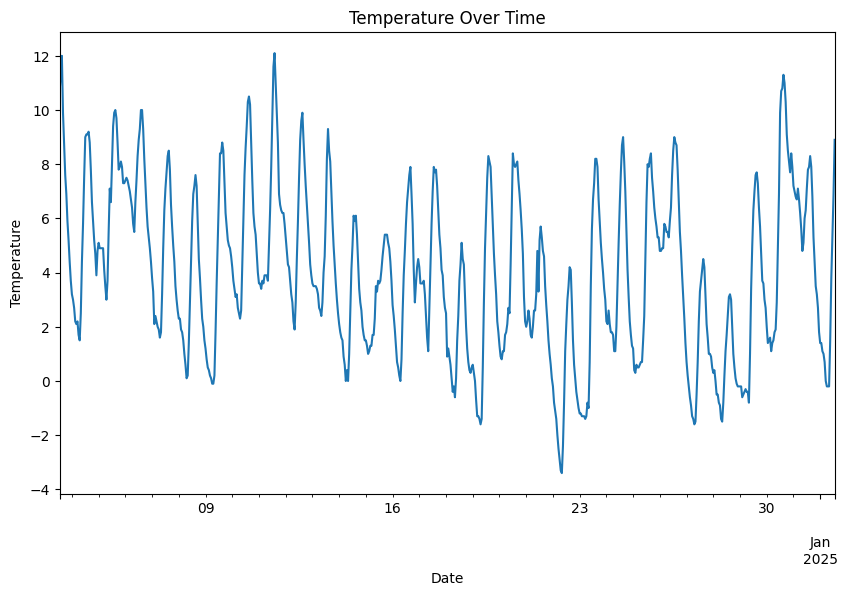

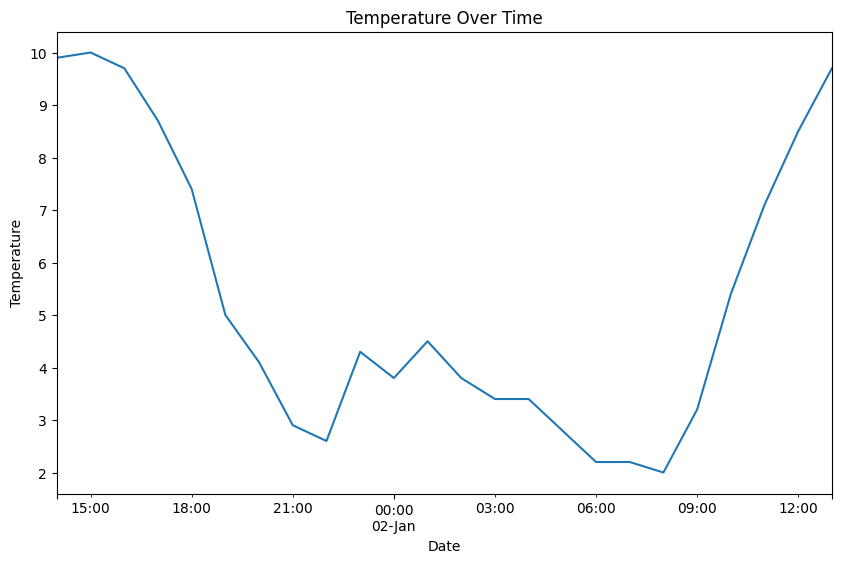

In [ ]:
#데이터 다운로드
steps = 24
temp_list = temp_totalData()
val_list = temp_list[-1*steps:] #가장 최근 24시간 데이터를 Validation 데이터로 분류
temp_list = temp_list[:len(temp_list)-steps]
data_plot(temp_list)
data_plot(val_list)

In [ ]:
#시계열 데이터의 정상성을 확인. p-value < 0.05 => 통과
from statsmodels.tsa.stattools import adfuller
import pandas as pd
result = adfuller(temp_list)
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -2.0891163924939873
p-value: 0.24891341516725207


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dat

최적 파라미터: (2, 1, 2), AIC: 1105.6704776532044
예측된 값 10.13이 상한값을 초과함. 0시간 후 문제 발생 예정


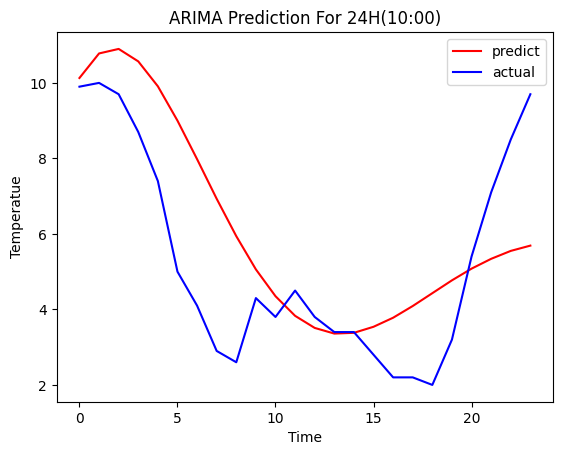

In [ ]:
#ARIMA Model code
import itertools

# SARIMA 파라미터 범위 정의
d = p = q = range(0, 3)
m = 24 # 계절성 주기 = 24시간

# 가능한 파라미터 조합 생성
param_combinations = list(itertools.product(p, d, q))

# 최적의 파라미터 탐색
best_aic = float("inf")
best_params = None
best_model = None

for params in param_combinations:
    try:
        model = ARIMA(temp_list['temperature'], order=(params[0], params[1], params[2])).fit()
        if model.aic < best_aic:
            best_aic = model.aic
            best_params = params
            best_model = model
    except:
        continue

print(f"최적 파라미터: {best_params}, AIC: {best_aic}")


# 미래 예측
steps = 24 #데이터 간격에 따라 다름. 현재 사용 데이터는 1시간 간격이기 때문에 24시간 예측을 의미.
forecast = best_model.forecast(steps=steps)

forecast = round(forecast,2)

time_list = [i for i in range(steps)]
plt.plot(time_list,forecast, label='predict', color='red')
plt.plot(time_list, val_list[:steps], label='actual', color='blue')
plt.title('ARIMA Prediction For 24H(10:00)')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Temperatue')

plt.show()

# AIC 프린트하기
#print('The MSE of auto-arima is:', mean_squared_error(nyc_v['death'].values, fcast2.values, squared=False))

In [ ]:
#오차범위를 벗어나는 실제값 확인
i = 0
for e in zip(forecast.values, val_list.values):
  #기상청에서 인정하는 기온의 오차범위는 2도.
  error_range = 2
  predict = e[0]
  actual = e[1]
  lower_hat = predict - error_range
  upper_hat = predict + error_range
  if lower_hat > actual or actual > upper_hat:
      if lower_hat > actual:
        print(f"{i}시점에서 예측값보다 실제값이 더 낮습니다.")
      else:
        print(f"{i}시점에서 예측값보다 실제값이 더 높습니다.")
  i = i + 1

9시점에서 예측값보다 실제값이 더 낮습니다.
10시점에서 예측값보다 실제값이 더 낮습니다.
11시점에서 예측값보다 실제값이 더 낮습니다.
21시점에서 예측값보다 실제값이 더 낮습니다.


In [ ]:
pip install pmdarima #Auto-ARIMA Model을 사용하기 위해서는 패키지 다운 필수

/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (24) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/pyt

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1244.793, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1479.316, Time=0.11 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1241.072, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1304.163, Time=0.16 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1477.316, Time=0.05 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1240.707, Time=0.21 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1242.705, Time=0.24 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1242.707, Time=0.43 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1240.793, Time=0.27 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1244.533, Time=0.67 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1238.710, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1239.074, Time=0.07 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(0,0,0)[0]             : AIC=1240.707, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1240.709, Time=0.18 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1238.795, Time=0.12 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1242.535, Time=0.29 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 3.589 seconds
예측된 값 30.25이 상한값을 초과함. 0시간 후 문제 발생 예정


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


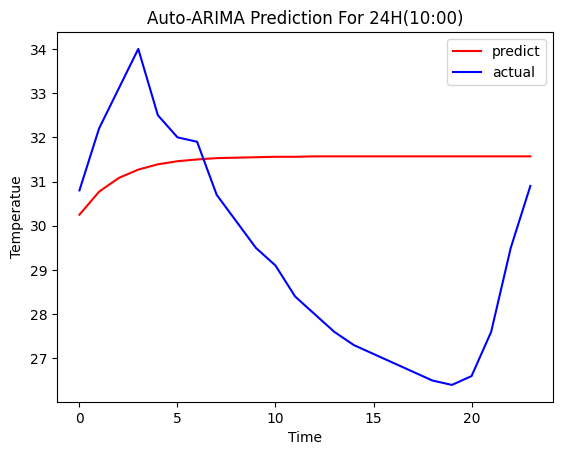

In [ ]:
#Auto_ARIMA Model

import pmdarima as pm
# 일주일치 시계열 데이터 (시간, 값)

# ARIMA 모델 학습: p, d, q 값은 데이터에 맞게 조정
model = pm.auto_arima(temp_list['temperature'], seasonal=False, m=24, stepwise=True, trace=True)

# 미래 예측
steps = 24 #데이터 간격에 따라 다름. 현재 사용 데이터는 1시간 간격이기 때문에 24시간 예측을 의미.
fcast2 = model.predict(steps)
fcast2 = pd.Series(fcast2)

fcast2 = round(fcast2,2)

time_list = [i for i in range(steps)]
plt.plot(time_list,fcast2, label='predict', color='red')
plt.plot(time_list, val_list[:steps], label='actual', color='blue')
plt.title('Auto-ARIMA Prediction For 24H(10:00)')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Temperatue')

plt.show()

In [ ]:
i = 0
for e in zip(fcast2.values, val_list.values):
  #기상청에서 인정하는 기온의 오차범위는 2도.
  error_range = 2
  predict = e[0]
  actual = e[1]
  lower_hat = predict - error_range
  upper_hat = predict + error_range
  if lower_hat > actual or actual > upper_hat:
      if lower_hat > actual:
        print(f"{i}시점에서 예측값보다 실제값이 더 낮습니다.")
      else:
        print(f"{i}시점에서 예측값보다 실제값이 더 높습니다.")
  i = i + 1

9시점에서 예측값보다 실제값이 더 낮습니다.
10시점에서 예측값보다 실제값이 더 낮습니다.
11시점에서 예측값보다 실제값이 더 낮습니다.
21시점에서 예측값보다 실제값이 더 낮습니다.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dat

최적 파라미터: (1, 1, 0, 1, 1, 1), AIC: 1101.5079084681097


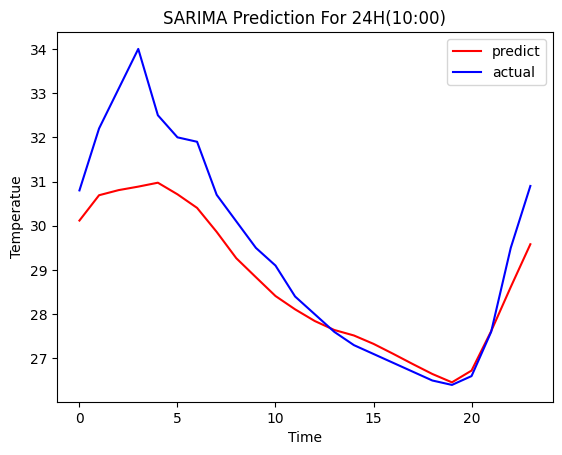

In [ ]:
#SARIMA 보델
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools

# SARIMA 파라미터 범위 정의
d = [1]
p = q = range(0, 2)
P = [1]
D = Q = range(0, 2)
m = 24 # 계절성 주기 = 24시간

# 가능한 파라미터 조합 생성
param_combinations = list(itertools.product(p, d, q, P, D, Q))

# 최적의 파라미터 탐색
best_aic = float("inf")
best_params = None
best_model = None


for params in param_combinations:
    try:
        model = SARIMAX(temp_list, order=(params[0], params[1], params[2]),
                        seasonal_order=(params[3], params[4], params[5], m)).fit()
        if model.aic < best_aic:
            best_aic = model.aic
            best_params = params
            best_model = model
    except:
        continue

print(f"최적 파라미터: {best_params}, AIC: {best_aic}")

# 예측
forecast = best_model.predict(start=len(temp_list), end=len(temp_list)+23, dynamic=False)

# 예측 결과 시각화
time_list = [i for i in range(steps)]
plt.plot(time_list,forecast, label='predict', color='red')
plt.plot(time_list, val_list[:steps], label='actual', color='blue')
plt.title('SARIMA Prediction For 24H(10:00)')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Temperatue')

plt.show()


In [ ]:
i = 0
for e in zip(forecast.values, val_list.values):
  #기상청에서 인정하는 기온의 오차범위는 2도.
  error_range = 2
  predict = e[0]
  actual = e[1]
  lower_hat = predict - error_range
  upper_hat = predict + error_range
  if lower_hat > actual or actual > upper_hat:
      if lower_hat > actual:
        print(f"{i}시점에서 예측값보다 실제값이 더 낮습니다.")
      else:
        print(f"{i}시점에서 예측값보다 실제값이 더 높습니다.")
  i = i + 1

5시점에서 예측값보다 실제값이 더 높습니다.
6시점에서 예측값보다 실제값이 더 높습니다.
14시점에서 예측값보다 실제값이 더 높습니다.
